## Import libraries

In [1]:
import pandas as pd
import joblib
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Load Data

In [2]:
# Load the test data
file_path = r'C:\Users\nmilo\OneDrive\Desktop\Studium\Bachelorarbeit\pfr.combine\new_data_final_cleaned.xlsx'
df = pd.read_excel(file_path)

# Define the features and target
df['NFL_Games_Binary'] = (df['NFL Games'] > 17).astype(int)
features = df.drop(columns=['NFL Games', 'NFL_Games_Binary', 'Player', 'Pos', 'Ht', 'Drafted', 'NFL Snaps', 'Personal Accolades'])
target = df['NFL_Games_Binary']


## Load and standardize trained models

In [3]:
# Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features.columns)

# Load trained models
log_reg_model = joblib.load('log_reg_model.pkl')
rf_model = joblib.load('rf_model.pkl')
gb_model = joblib.load('gb_model.pkl')
svm_model = joblib.load('svm_model.pkl')


## Generate Predictions and calculate ROC

In [4]:
# Generate predictions and probabilities using the DataFrame with feature names
y_pred_proba_lr = log_reg_model.predict_proba(X_test_scaled_df)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled_df)[:, 1]
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled_df)[:, 1]
y_pred_proba_svm = svm_model.decision_function(X_test_scaled_df)

# Calculate ROC AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

# Print the calculated ROC AUC values to check correctness
print(f'Logistic Regression ROC AUC: {roc_auc_lr}')
print(f'Random Forest ROC AUC: {roc_auc_rf}')
print(f'Gradient Boosting ROC AUC: {roc_auc_gb}')
print(f'SVM ROC AUC: {roc_auc_svm}')


Logistic Regression ROC AUC: 0.7888218438309362
Random Forest ROC AUC: 0.7745219595525431
Gradient Boosting ROC AUC: 0.7996294153303577
SVM ROC AUC: 0.7456879925056484


## Plot curves

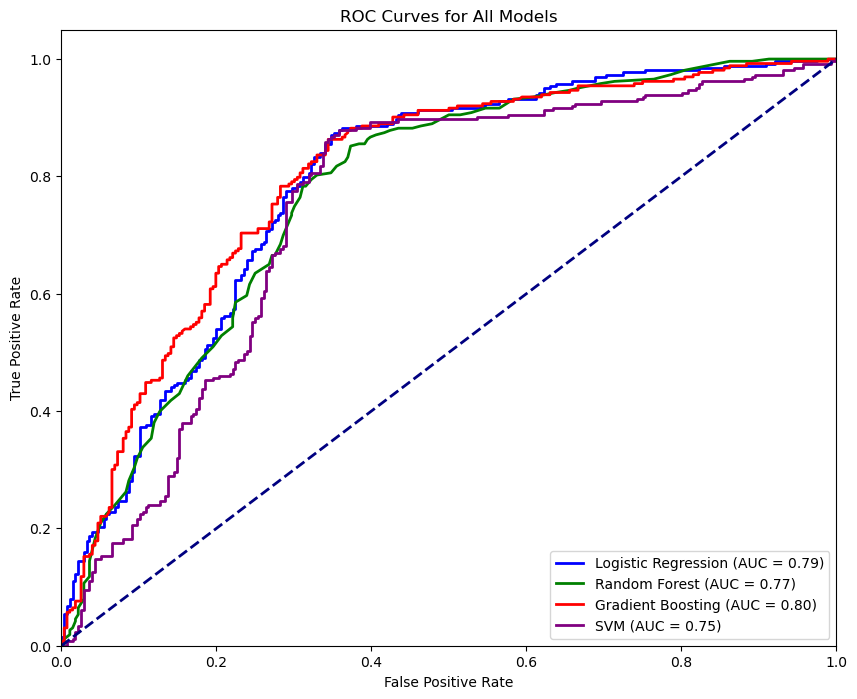

In [5]:
# Generate ROC curve data
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, color='red', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.show()


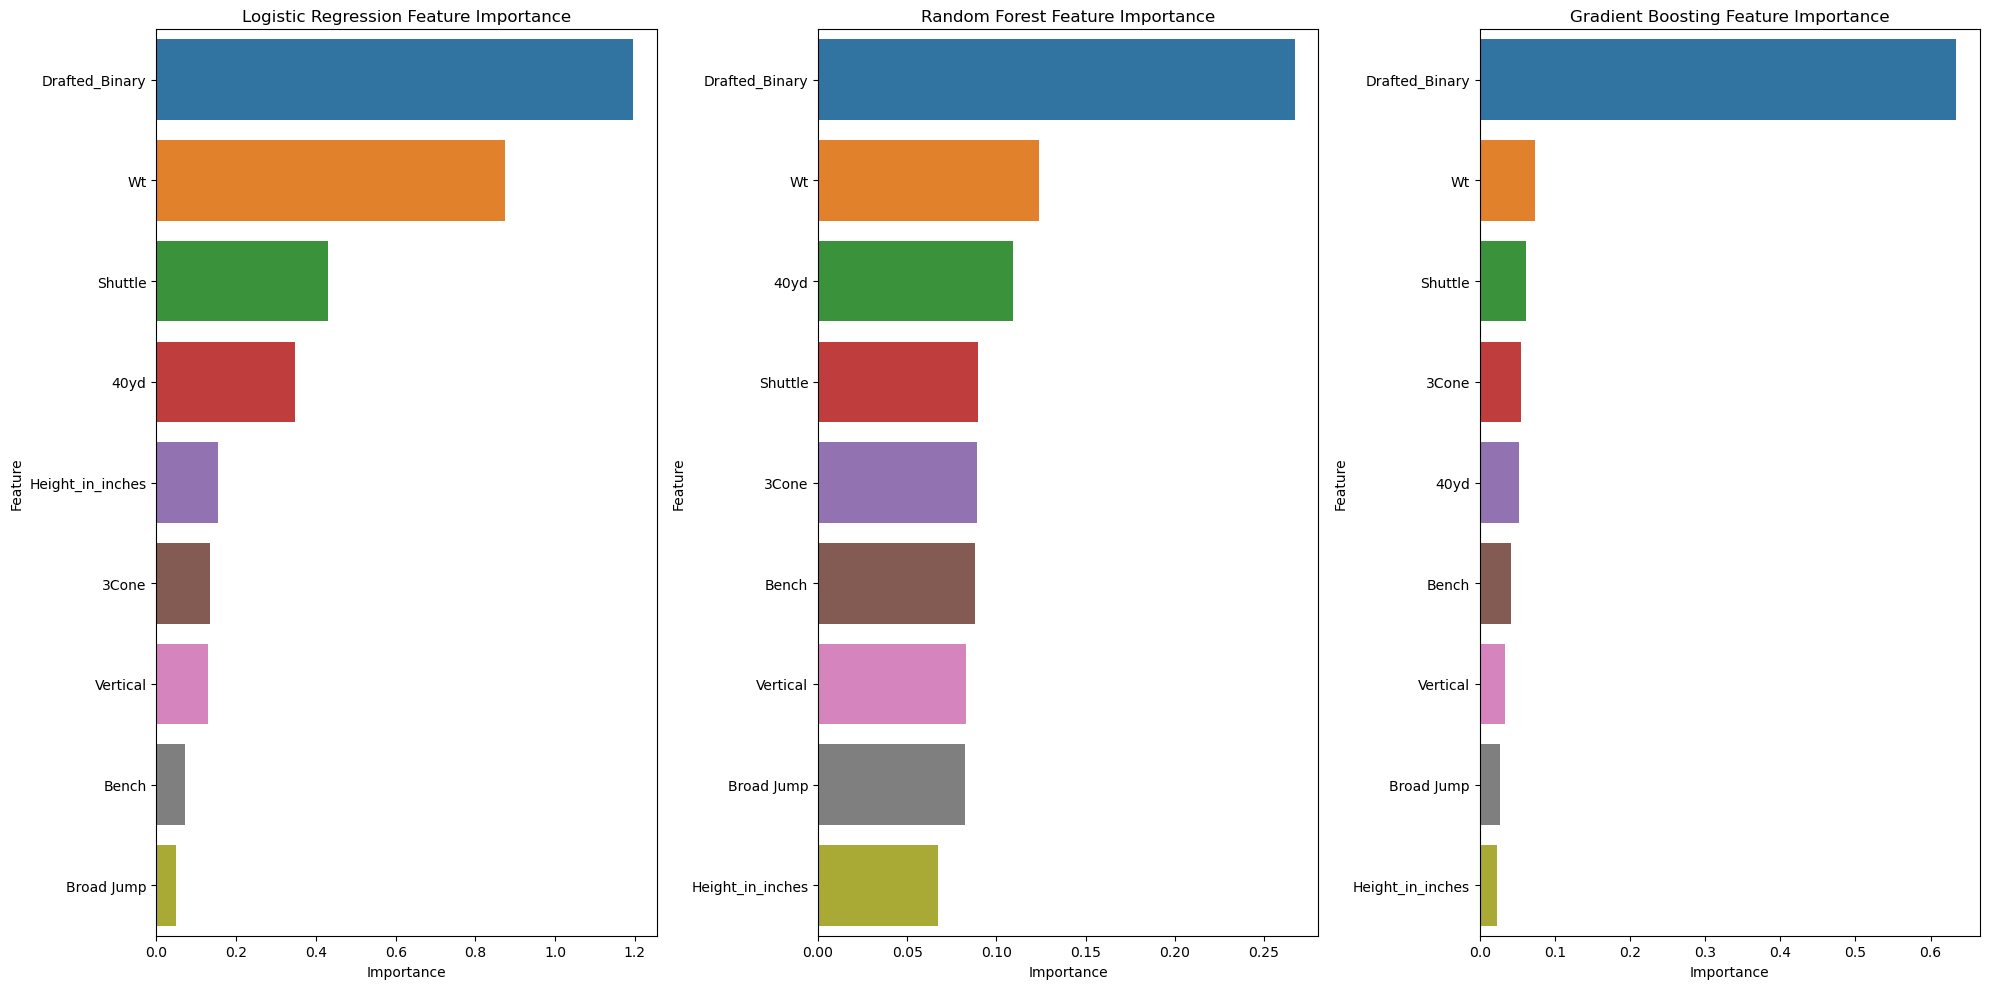

In [6]:
# Logistic Regression Feature Importance
coefficients = log_reg_model.coef_[0]
feature_importance_lr = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance_lr.sort_values(by='Importance', ascending=False, inplace=True)

# Random Forest Feature Importance
importances_rf = rf_model.feature_importances_
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_rf})
feature_importance_rf.sort_values(by='Importance', ascending=False, inplace=True)

# Gradient Boosting Feature Importance
importances_gb = gb_model.feature_importances_
feature_importance_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_gb})
feature_importance_gb.sort_values(by='Importance', ascending=False, inplace=True)

# Plotting all feature importances together
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

# Logistic Regression
sns.barplot(ax=axes[0], x='Importance', y='Feature', data=feature_importance_lr)
axes[0].set_title('Logistic Regression Feature Importance')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')

# Random Forest
sns.barplot(ax=axes[1], x='Importance', y='Feature', data=feature_importance_rf)
axes[1].set_title('Random Forest Feature Importance')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

# Gradient Boosting
sns.barplot(ax=axes[2], x='Importance', y='Feature', data=feature_importance_gb)
axes[2].set_title('Gradient Boosting Feature Importance')
axes[2].set_xlabel('Importance')
axes[2].set_ylabel('Feature')

plt.tight_layout()
plt.show()


## Crossvalidation

Cross-Validation Results:
Logistic Regression: 0.7945
Random Forest: 0.7887
Gradient Boosting: 0.7927
SVM: 0.7824
                 Model  Original Validation Scores (ROC AUC)  \
0  Logistic Regression                              0.788822   
1        Random Forest                              0.774522   
2    Gradient Boosting                              0.799629   
3                  SVM                              0.745688   

   Cross-Validation Results (ROC AUC)  
0                            0.794479  
1                            0.788748  
2                            0.792685  
3                            0.782404  


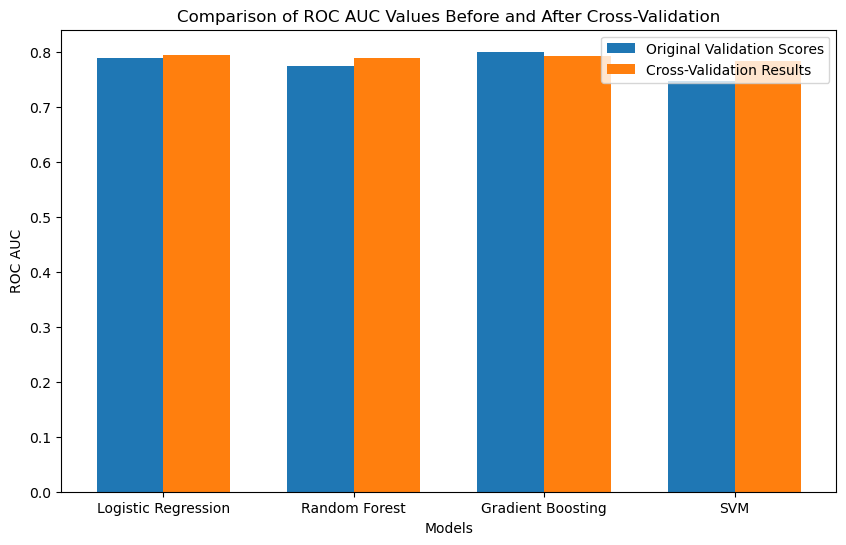

In [7]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_log_reg = cross_val_score(log_reg_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
cv_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
cv_gb = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
cv_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

# Cross-Validation Results
cv_results = {
    'Logistic Regression': cv_log_reg.mean(),
    'Random Forest': cv_rf.mean(),
    'Gradient Boosting': cv_gb.mean(),
    'SVM': cv_svm.mean()
}

# Display results
print("Cross-Validation Results:")
for model, auc in cv_results.items():
    print(f"{model}: {auc:.4f}")

# Create and visualize the table
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'SVM'],
    'Original Validation Scores (ROC AUC)': [roc_auc_lr, roc_auc_rf, roc_auc_gb, roc_auc_svm],
    'Cross-Validation Results (ROC AUC)': list(cv_results.values())
})

# Display the table
print(results_df)

# Visualization
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(results_df))
plt.bar(index, results_df['Original Validation Scores (ROC AUC)'], bar_width, label='Original Validation Scores')
plt.bar(index + bar_width, results_df['Cross-Validation Results (ROC AUC)'], bar_width, label='Cross-Validation Results')
plt.xlabel('Models')
plt.ylabel('ROC AUC')
plt.title('Comparison of ROC AUC Values Before and After Cross-Validation')
plt.xticks(index + bar_width / 2, results_df['Model'])
plt.legend()
plt.show()
